# Preprocess

## Unzip files.

In [1]:
!unzip -qq ./download/seg_saitama_morning.zip -d download
!unzip -qq ./download/seg_tokyo1_day.zip -d download
!unzip -qq ./download/seg_tokyo1_morning.zip -d download
!unzip -qq ./download/seg_tokyo1_night.zip -d download
!unzip -qq ./download/seg_tokyo2_day.zip -d download

In [2]:
!mkdir -p ./data/annotations/
!mkdir -p ./data/images/
!mv ./download/seg_saitama_morning/annotations/* ./data/annotations/
!mv ./download/seg_saitama_morning/images/* ./data/images/
!mv ./download/seg_tokyo1_day/annotations/* ./data/annotations/
!mv ./download/seg_tokyo1_day/images/* ./data/images/
!mv ./download/seg_tokyo1_morning/annotations/* ./data/annotations/
!mv ./download/seg_tokyo1_morning/images/* ./data/images/
!mv ./download/seg_tokyo1_night/annotations/* ./data/annotations/
!mv ./download/seg_tokyo1_night/images/* ./data/images/
!mv ./download/seg_tokyo2_day/annotations/* ./data/annotations/
!mv ./download/seg_tokyo2_day/images/* ./data/images/

In [3]:
!rm -rf download/__MACOSX
!rm -rf download/seg_saitama_morning
!rm -rf download/seg_tokyo1_day
!rm -rf download/seg_tokyo1_morning
!rm -rf download/seg_tokyo1_night
!rm -rf download/seg_tokyo2_day

## Import

In [4]:
%matplotlib inline

import os
import glob
import pathlib
import shutil
import json
import random

import cv2

import numpy as np

from tqdm import tqdm

from skimage.io import imshow

import matplotlib.pyplot as plt

To get started, we would advise you to download all the files, and move them inside the object/data/ folder, so that you have a directory structure like this :

```
+- data
    +- annotations
        +- *.jpg
    +- images
        +- *.jpg
```

In [5]:
TRAIN_IMAGES_DIRECTORY = "./data/images"
TRAIN_ANNOTATIONS_DIRECTORY = "./data/annotations"

In [6]:
train_annotations_files = glob.glob(os.path.join(TRAIN_ANNOTATIONS_DIRECTORY, '*.png'))
train_images_files = glob.glob(os.path.join(TRAIN_IMAGES_DIRECTORY, '*.jpg'))

train_annotations_files.sort()
train_images_files.sort()

print('train annotaions files : ', len(train_annotations_files))
print('train images files     : ', len(train_images_files))

train annotaions files :  2243
train images files     :  2243


## Data Augmentation
- Horizontal flip

In [7]:
for i, path in tqdm(enumerate(train_images_files)):
    file_name = os.path.splitext(os.path.basename(path))[0]

    # Read image (data).
    im = cv2.imread(path)
    flip_im = cv2.flip(im, 1) # flip lr
    
    # Read image (annotation).
    annotation_im = cv2.imread(train_annotations_files[i])
    flip_annotations_im = cv2.flip(annotation_im, 1) # flip lr
    
    # Write image (flip lr).
    cv2.imwrite(os.path.join(TRAIN_IMAGES_DIRECTORY, file_name + '_flip.jpg'), flip_im)
    
    # Write image (annotation).
    cv2.imwrite(os.path.join(TRAIN_ANNOTATIONS_DIRECTORY, file_name + '_flip.png'), flip_annotations_im)

2243it [03:14, 11.55it/s]


In [8]:
train_annotations_files = glob.glob(os.path.join(TRAIN_ANNOTATIONS_DIRECTORY, '*.png'))
train_images_files = glob.glob(os.path.join(TRAIN_IMAGES_DIRECTORY, '*.jpg'))

train_annotations_files.sort()
train_images_files.sort()

print('train annotaions files : ', len(train_annotations_files))
print('train images files     : ', len(train_images_files))

train annotaions files :  4486
train images files     :  4486


## Category and annotation color label

|Category|R|G|B|
|:--|--:|--:|--:|
|Car|0|0|255|
|Bus|193|214|0|
|Truck|180|0|129|
|SVehicle|255|121|166|
|Pedestrian|255|0|0|
|Motorbike|65|166|1|
|Bicycle|208|149|1|
|Signal|255|255|0|
|Signs|255|134|0|
|Sky|0|152|225|
|Building|0|203|151|
|Natural|85|255|50|
|Wall|92|136|125|
|Lane|69|47|142|
|Ground|136|45|66|
|Sidewalk|0|255|255|
|RoadShoulder|215|0|255|
|Obstacle|180|131|135|
|others|81|99|0|
|own|86|62|67|

## Pascal VOC color map

|Index|Category|
|--:|:--|
|0|others,own|
|1|Car
|2|Bus
|3|Truck
|4|SVehicle
|5|Pedestrian
|6|Motorbike
|7|Bicycle
|8|Signal
|9|Signs
|10|Sky
|11|Building
|12|Natural
|13|Wall
|14|Lane
|15|Ground
|16|Sidewalk
|17|RoadShoulder
|18|Obstacle

In [9]:
def create_pascal_label_colormap():
    """ Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=np.uint8)
    ind = np.arange(256, dtype=np.uint8)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    return colormap

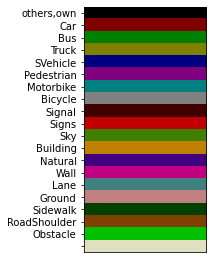

In [10]:
labels = ['others,own', 'Car', 'Bus', 'Truck', 'SVehicle', 'Pedestrian', 'Motorbike', 'Bicycle', 'Signal', 'Signs', 'Sky', 'Building', 'Natural', 'Wall', 'Lane', 'Ground', 'Sidewalk', 'RoadShoulder', 'Obstacle']
nclasses = 19
row_size = 50
col_size = 500
cmap = create_pascal_label_colormap()
array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
for i in range(nclasses):
    array[i*row_size:i*row_size+row_size, :] = cmap[i]
array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

imshow(array)

plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
plt.xticks([])
plt.show()

## Create SegmentationClass

In [11]:
class_dir = os.path.join('./data', 'SegmentationClassRaw')
if os.path.isdir(class_dir) == True:
    shutil.rmtree(class_dir)
os.makedirs(class_dir)

In [12]:
annotation_color_labels = {'Car':[0, 0, 255], 'Bus':[193, 214, 0], 'Truck':[180, 0, 129],
                          'SVehicle':[255, 121, 166], 'Pedestrian':[255, 0, 0], 'Motorbike':[65, 166, 1],
                          'Bicycle':[208, 149, 1], 'Signal':[255, 255, 0], 'Signs':[255, 134, 0],
                          'Sky':[0, 152, 225], 'Building':[0, 203, 151], 'Natural':[85, 255, 50],
                          'Wall':[92, 136, 125], 'Lane':[69, 47, 142], 'Ground':[136, 45, 66],
                          'Sidewalk':[0, 255, 255], 'RoadShoulder':[215, 0, 255], 'Obstacle':[180, 131, 135],
                          'others':[81, 99, 0], 'own':[86, 62, 67]}

In [13]:
pascal_voc_color_map = {'others':0, 'own':0, 'Car':1, 'Bus':2, 'Truck':3, 'SVehicle':4, 'Pedestrian':5,
                        'Motorbike':6, 'Bicycle':7, 'Signal':8, 'Signs':9, 'Sky':10, 'Building':11,
                        'Natural':12, 'Wall':13, 'Lane':14, 'Ground':15, 'Sidewalk':16, 'RoadShoulder':17,
                        'Obstacle':18 }

In [14]:
for path in tqdm(train_annotations_files):
    basename = os.path.basename(path)
    
    # Read image.
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    height, width = im.shape[:2]
    gray_im = np.zeros((height, width, 1), dtype=np.uint8)
    
    for label in annotation_color_labels:
        color_label = annotation_color_labels[label]
        color_map = pascal_voc_color_map[label]
        
        lower = np.array(color_label)
        upper = np.array(color_label)
        mask_im = cv2.inRange(im, lower, upper)
        
        _, contours, hierarchy = cv2.findContours(mask_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for i in range(len(contours)):
            cv2.drawContours(gray_im, contours, -1, (color_map), -1)
            cv2.drawContours(gray_im, contours, -1, (255), 1)
            
            
        cv2.imwrite(os.path.join(class_dir, basename), gray_im)

100%|██████████| 4486/4486 [20:30<00:00,  3.64it/s]


## Split data and create train and val txt file

In [15]:
random.seed(42)
random.shuffle(train_images_files)
num_examples = int(len(train_images_files) * 1.0)
num_train = int(0.8 * num_examples)
num_val = int(0.2 * num_examples)
train_examples = train_images_files[:num_train]
val_examples = train_images_files[num_train:num_train+num_val]
print('all', num_examples, 'train num', len(train_examples), ' val num', len(val_examples))

all 4486 train num 3588  val num 897


In [16]:
segmentation_dir = os.path.join('.', 'data', 'ImageSets', 'Segmentation')
if os.path.isdir(segmentation_dir) == True:
    shutil.rmtree(segmentation_dir)
os.makedirs(segmentation_dir)

In [17]:
file = open(os.path.join(segmentation_dir, 'train.txt'), 'w')
for i, f in enumerate(train_examples):
    file.write(os.path.splitext(os.path.basename(f))[0]+"\n")
file.close()

In [18]:
file = open(os.path.join(segmentation_dir, 'val.txt'), 'w')
for i, f in enumerate(val_examples):
    file.write(os.path.splitext(os.path.basename(f))[0]+"\n")
file.close()

In [19]:
train_fine_examples = random.sample(train_examples, int(num_train * 0.2))
print(len(train_fine_examples))

file = open(os.path.join(segmentation_dir, 'train_fine.txt'), 'w')
for i, f in enumerate(train_fine_examples):
    file.write(os.path.splitext(os.path.basename(f))[0]+"\n")
file.close()

717
